In [ ]:
#!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt

# Import Data
Download data from yahoo finance directly instead of referencing csv

In [3]:
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']
stock_data = yf.download(symbols_list, start="2000-01-01", end="2020-01-01")
prices = stock_data["Adj Close"]
print(prices.shape)
prices.head()

[*********************100%***********************]  10 of 10 completed
(5033, 10)


,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
1999-12-31,0.793253,76.1250,12.361215,35.840862,12.204452,NaN,3.124838,NaN,NaN,47.249874
2000-01-03,0.863657,89.3750,11.420005,33.900600,11.811604,NaN,3.068704,NaN,NaN,50.373814
2000-01-04,0.790842,81.9375,10.918026,32.620586,11.824701,NaN,3.171617,NaN,NaN,48.030865
2000-01-05,0.802415,69.7500,11.231760,31.907393,11.929461,NaN,3.442935,NaN,NaN,50.503986
2000-01-06,0.732975,65.5625,12.298465,32.557430,11.942557,NaN,3.349378,NaN,NaN,49.462685


In [6]:
market_prices = yf.download("SPY", start="2000-01-01", end="2020-01-01")["Adj Close"]
print(market_prices.shape)
market_prices.tail()

[*********************100%***********************]  1 of 1 completed
(5032,)


Date
2019-12-24    316.685272
2019-12-26    318.371063
2019-12-27    318.292175
2019-12-30    316.537384
2019-12-31    317.306335
Name: Adj Close, dtype: float64

In [7]:
mkt_caps = {}
for symbol in symbols_list:
    stock = yf.Ticker(symbol)
    print(stock.info["marketCap"])
    mkt_caps[symbol] = stock.info["marketCap"]

mkt_caps

1966274379776
85395374080
5346873344
3827434496
19540854784
234527358976
4380848640
1598114627584
216747884544
396876120064


{'AAPL': 1966274379776,
 'AXP': 85395374080,
 'UAA': 5346873344,
 'APA': 3827434496,
 'SU': 19540854784,
 'NFLX': 234527358976,
 'XRX': 4380848640,
 'AMZN': 1598114627584,
 'KO': 216747884544,
 'TSLA': 396876120064}

# Constructing the prior

The prior distribution is the historical distribution of our stock's returns, volatility and covariance

In [8]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.5578327076007414

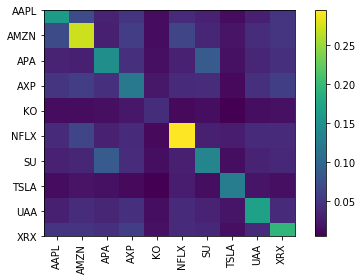

In [9]:
# Variance-Covariance matrix
plotting.plot_covariance(S);

In [10]:
market_prior = black_litterman.market_implied_prior_returns(mkt_caps, delta, S)
market_prior

AAPL    0.177776
AMZN    0.229543
APA     0.068890
AXP     0.095936
KO      0.045160
NFLX    0.114041
SU      0.070286
TSLA    0.062449
UAA     0.074180
XRX     0.090530
dtype: float64

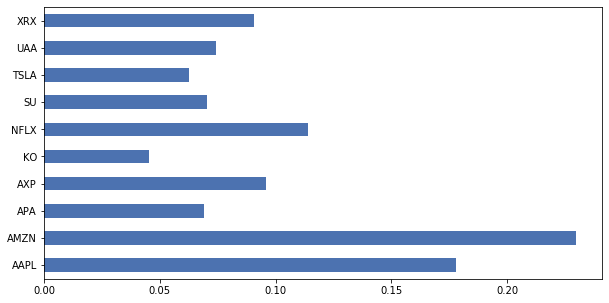

In [11]:
market_prior.plot.barh(figsize=(10,5));

# Personal investment views
Black Litterman model gives us the option to include our own personal investment beliefs of the range in which a stocks returns may vary, as well as our confidence intervals in these beliefs

In [12]:
# You don't have to provide views on all the assets
viewdict = {
    "AAPL": 0.10, # I think Apple will go up 10%
    "APA": 0.25,
    "AXP": 0.05,
    "XRX": 0.05,
    "AMZN": 0.30, 
    "NFLX": 0.30,
    "UAA": 0.15,
    "SU": 0.10,
    "KO": 0.10,
    "TSLA": 0.30
}

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.05, 0.20),
    (-0.05, 0.10),
    (0.20, 0.35),
    (0.20, 0.45),
    (0.00, 0.2),
    (0.08, 0.12),
    (0.1, 0.2),
    (0.10, 0.50)
]


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

bl = BlackLittermanModel(S, pi="market", market_caps=mkt_caps, risk_averison="delta", absolute_views=viewdict, omega=omega)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.005624999999999997, 0.015625, 0.010000000000000002, 0.00039999999999999986, 0.0025000000000000005, 0.04000000000000001]


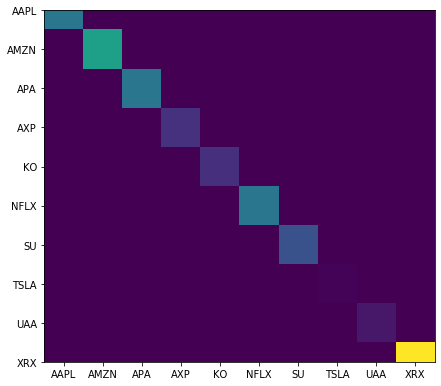

In [13]:
# Shows investor's forward view
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

# Estimate posterior returns
In layman terms:

Expected excess returns = Investor view * Past Market view

$$E(R-R_{rf}) = [(\tau*S)^{-1} + P^\text{T}\Omega^{-1}P]^{-1}]*[(\tau*S)^{-1}\Pi + P^\text{T}\Omega^{-1}Q]$$

$E(R-R_{rf}) = \text{Expected excess return}$

$P = \text{Matrix identifying which stocks you have views about}$

$Q = \text{Matrix of investor forward view of excess returns}$

$S = \text{Variance-Covariance Matrix}$

$\tau = \text{Scalar assume = 1}$

$\Omega = \text{Uncertainty surrounding your future views}$

$\Pi = \text{Implied excess returns derived from prior}$



In [15]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.135895
AMZN    0.236905
APA     0.113636
AXP     0.092531
KO      0.060879
NFLX    0.199307
SU      0.099432
TSLA    0.114124
UAA     0.115342
XRX     0.075382
dtype: float64

In [16]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.177776,0.135895,0.10
AMZN,0.229543,0.236905,0.30
APA,0.068890,0.113636,0.25
AXP,0.095936,0.092531,0.05
KO,0.045160,0.060879,0.10
NFLX,0.114041,0.199307,0.30
SU,0.070286,0.099432,0.10
TSLA,0.062449,0.114124,0.30
UAA,0.074180,0.115342,0.15
XRX,0.090530,0.075382,0.05


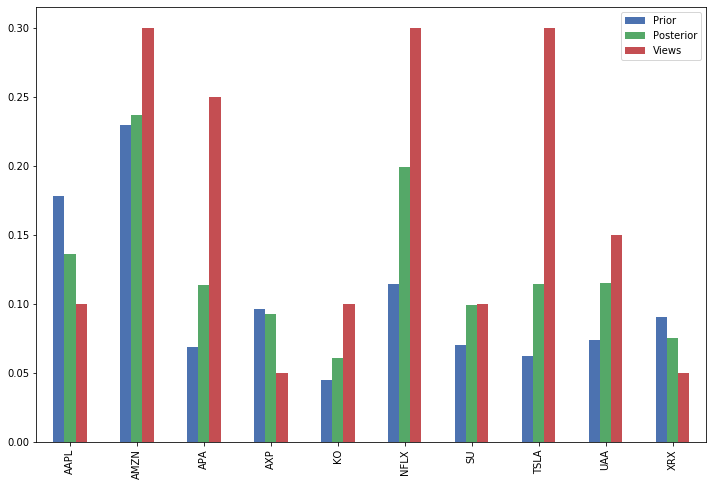

In [17]:
rets_df.plot.bar(figsize=(12,8));

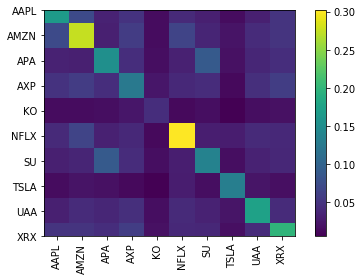

In [18]:
# Estimate of covariance matrix, factoring investor views
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [19]:
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(0,0.25))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_constraint(lambda x : x >= 0.025)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\Marcus\Anaconda3\lib\site-packages\pypfopt\efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AAPL', 0.10735),
             ('AMZN', 0.23844),
             ('APA', 0.09074),
             ('AXP', 0.025),
             ('KO', 0.06576),
             ('NFLX', 0.16563),
             ('SU', 0.04614),
             ('TSLA', 0.15663),
             ('UAA', 0.07931),
             ('XRX', 0.025)])

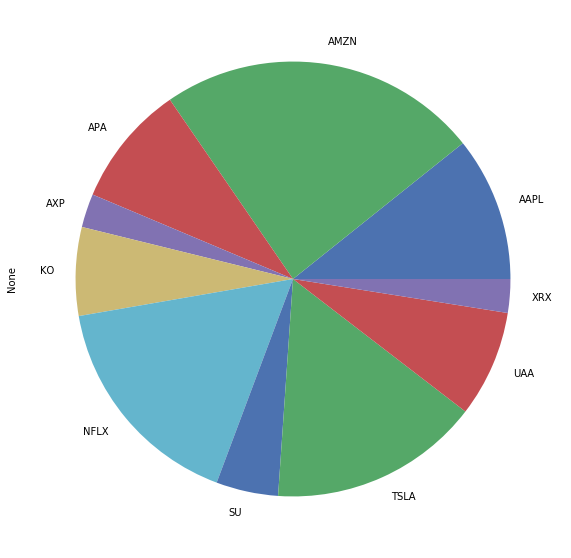

In [20]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [22]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $3.76


{'AAPL': 146.0,
 'AMZN': 13.0,
 'APA': 359.0,
 'AXP': 21.0,
 'KO': 122.0,
 'NFLX': 51.0,
 'SU': 145.0,
 'TSLA': 186.0,
 'UAA': 367.0,
 'XRX': 71.0}

In [23]:
print("Black-Litterman Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef.portfolio_performance()))

Black-Litterman Portfolio Analysis:
	Expected annual return: 0.154209
	Annual Volatility: 0.249908
	Sharpe ratio: 0.537035


# Allow shorting
Allow the portfolio to allocate negative weights by shorting stocks

In [24]:
ef_with_short = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef_with_short.add_objective(objective_functions.L2_reg, gamma=0.1)
ef_with_short.max_sharpe()
weights_with_short = ef_with_short.clean_weights()
weights_with_short

OrderedDict([('AAPL', 0.1187),
             ('AMZN', 0.2485),
             ('APA', 0.10001),
             ('AXP', 0.00745),
             ('KO', 0.07565),
             ('NFLX', 0.17236),
             ('SU', 0.05348),
             ('TSLA', 0.16283),
             ('UAA', 0.08831),
             ('XRX', -0.02729)])

In [25]:
print("Black-Litterman with shorts Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef_with_short.portfolio_performance()))

Black-Litterman with shorts Portfolio Analysis:
	Expected annual return: 0.158042
	Annual Volatility: 0.253622
	Sharpe ratio: 0.544284
